In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

#!pip install mpld3
import mpld3
mpld3.enable_notebook()

# Compute SEIRD differential equations

In [2]:
# Create SEIR Differenctial equations

def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

# Load Africa lines list data

In [3]:
# Load infections, deaths and recover data into dataframes

import pandas as pd

africa_infections_url = "https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/time_series/africa_daily_time_series_cases.csv"
africa_deaths_url = "https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/time_series/africa_daily_time_series_deaths.csv"
africa_recoveries_url = "https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/time_series/africa_daily_time_series_recovered.csv"

africa_infections_df = pd.read_csv(africa_infections_url).transpose()
africa_infections_df.columns = africa_infections_df.iloc[0]
africa_infections_df = africa_infections_df.drop("Country/Region")
africa_infections_df = africa_infections_df.drop(["Lat","Long"])

africa_deaths_df = pd.read_csv(africa_deaths_url).transpose()
africa_deaths_df.columns = africa_deaths_df.iloc[0]
africa_deaths_df = africa_deaths_df.drop("Country/Region")
africa_deaths_df = africa_deaths_df.drop(["Lat","Long"])

africa_recoveries_df = pd.read_csv(africa_recoveries_url).transpose()
africa_recoveries_df.columns = africa_recoveries_df.iloc[0]
africa_recoveries_df = africa_recoveries_df.drop("Country/Region")
africa_recoveries_df = africa_recoveries_df.drop(["Lat","Long"])


In [4]:
# Change date format

africa_infections_df.index = pd.to_datetime(africa_infections_df.index)
africa_deaths_df.index = pd.to_datetime(africa_deaths_df.index)
africa_recoveries_df.index = pd.to_datetime(africa_recoveries_df.index)

africa_recoveries_df.head()

Country/Region,Algeria,Angola,Benin,Burkina Faso,Cabo Verde,Cameroon,CAR,Chad,Congo,DRC,...,Uganda,Zambia,Zimbabwe,Botswana,Burundi,Sierra Leone,Malawi,South Sudan,Western Sahara,Sao Tome and Principe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Load population data

pop_url = "https://raw.githubusercontent.com/datasets/population/master/data/population.csv"
pop_df = pd.read_csv(pop_url)

pop_df.head()

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1960,92197753
1,Arab World,ARB,1961,94724510
2,Arab World,ARB,1962,97334442
3,Arab World,ARB,1963,100034179
4,Arab World,ARB,1964,102832760


# Compute SEIRDs for South Africa as initial example

In [9]:
# Looking at South Africa as an example

country = "South Africa"
N = pop_df.loc[(pop_df["Country Name"] == country) & (pop_df["Year"] == 2018)]["Value"].values # Current Population

# Set initial conditions 

no_days_to_death = 14 # number of days to death after getting infection
D = 14 # how many days infection lasts for
alpha = 0.002 # death rate
no_days_to_death = 14  # How long an
incubation_period =  1 # number of days an exposed individual becomes infectious
date = "2020-05-20"
no_infections = africa_infections_df.loc[date, country]
no_deaths = africa_deaths_df.loc[date, country]
no_recoveries = africa_recoveries_df.loc[date, country]
R_0 = no_infections/no_recoveries

gamma = 1.0 / D
delta = 1.0 / incubation_period # incubation period of five days
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
rho = 1/no_days_to_death  # days from infection until death    
S0, E0, I0, R0, D0 = N, 0, no_infections, no_recoveries, no_deaths  # initial conditions: one exposed

t = np.linspace(0, 600, 150) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions v

#Solve differential equation with chosen initial conditions
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T


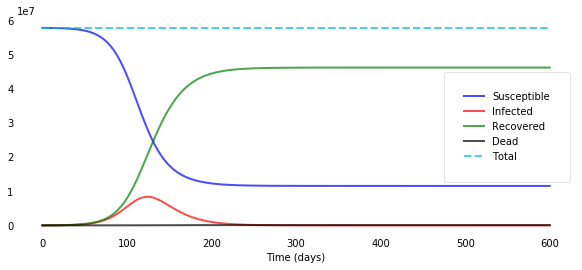

In [10]:
# Polot SEIRD curves 
    
f, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')


ax.set_xlabel('Time (days)')

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(borderpad=2.0)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();


# Interactive code for Africa

In [7]:
# install widgets

#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [8]:

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import datetime

@interact 
def plot_SEIRD(country = africa_infections_df.columns,
              date = widgets.DatePicker(value=pd.to_datetime(africa_infections_df.index[-1])),
              D = widgets.FloatText(value= 14), # how many days infection lasts for
              incubation_period =  widgets.FloatText(value= 1), # number of days an exposed individual becomes infectious
              alpha = widgets.FloatText(value=0.002), # death rate
              no_days_to_death = widgets.FloatText(value=14)          
             ):
    
                date = date.strftime("%Y-%m-%d")
                no_infections = africa_infections_df.loc[date, country]
                no_deaths = africa_deaths_df.loc[date, country]
                no_recoveries = africa_recoveries_df.loc[date, country]
                R_0 = no_infections/no_recoveries

                N = pop_df.loc[(pop_df["Country Name"] == country) & (pop_df["Year"] == 2018)]["Value"].values
                
                gamma = 1.0 / D
                delta = 1.0 / incubation_period # incubation period of five days
                beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
                rho = 1/no_days_to_death  # days from infection until death    
                S0, E0, I0, R0, D0 = N, 0, no_infections, no_recoveries, no_deaths  # initial conditions: one exposed
                
                t = np.linspace(0, 600, 150) # Grid of time points (in days)
                y0 = S0, E0, I0, R0, D0 # Initial conditions v
    
                ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
                S, E, I, R, D = ret.T
                
                f, ax = plt.subplots(1,1,figsize=(10,4))
                ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
                #ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
                ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
                ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
                ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
                ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')


                ax.set_xlabel('Time (days)')

                ax.yaxis.set_tick_params(length=0)
                ax.xaxis.set_tick_params(length=0)
                ax.grid(b=True, which='major', c='w', lw=2, ls='-')
                legend = ax.legend(borderpad=2.0)
                legend.get_frame().set_alpha(0.5)
                for spine in ('top', 'right', 'bottom', 'left'):
                    ax.spines[spine].set_visible(False)
                plt.show();

            
                return

interactive(children=(Dropdown(description='country', options=('Algeria', 'Angola', 'Benin', 'Burkina Faso', '…